In [2]:
%config Completer.use_jedi = False

In [3]:
import numpy as np
from scipy import optimize, interpolate, constants
import skelectrox as skx
import sympy as sym
from typing import Iterable
import matplotlib.pyplot as plt
from matplotlib import patches
plt.style.use('presentation')

In [4]:
R = constants.R
F = constants.physical_constants['Faraday constant'][0]
n = 2
Na = constants.physical_constants['Avogadro constant'][0]
R, F, Na

(8.314462618, 96485.33212, 6.02214076e+23)

# Theoritical 

The differential Impedance Analysis (DIA) is based on the use of a Local Operator Model (LOM)
which is a equivalent circuit for a simple Faradic reaction but has direct meaning with the 
experimental spectrum that is being analyzed.

The LOM operator corresponds to the equivalent circuit Rads-(R/C).

The procedure of the structural and parametric identification can be described by the following steps:
* scanning with the LOM throughout the whole frequency range with a scanning window of a single frequency.
* parametric identification of the LOM at every working frequency
* Frequency analysis of the LOM parameters' estimates

$$Z_{LOM} = R_{ads} + \frac{R}{1+\tau ^2\omega ^2} - j\frac{\omega R \tau}{1+\tau ^2\omega ^2}  $$ 

The objective is to identify the LOM parameters: $R_{ads}$, $R$, $\tau$, $C=R\tau$.

First the effective resistance and the effective inductance are expressed:
$$ R_{eff} = ReZ = R_{ads} + \frac{R}{1+\tau ^2\omega ^2} $$

$$ L_{eff} = -ImZ/\omega = \frac{R \tau}{1+\tau ^2\omega ^2} $$

Derivatives of the effective resistance and inductance are:
$$ \frac{dR_{eff}}{d\omega} = -R \frac{2\omega \tau ^2}{(1+\tau ^2\omega ^2)^2} $$

$$ ImZ = -L_{eff} \cdot \omega $$

$$ \frac{dImZ}{d\omega} = -\frac{ImZ}{dL_{eff}} \frac{dL_{eff}}{d\omega} = -\omega \frac{dL_{eff}}{d\omega} $$

$$ \frac{dL_{eff}}{d\omega} =  -R\tau \frac{2\tau ^2 \omega}{(1+\tau ^2\omega ^2)^2} = -\frac{dImZ}{d\omega} \frac{1}{\omega}$$

Expression of the LOM parameters:

$$\tau(\omega) = \frac{\frac{dL_{eff}}{d\omega}}{\frac{dR_{eff}}{d\omega}} = \frac{dL_{eff}}{dR_{eff}} $$

$$ R(\omega) = -\frac{dR_{eff}}{d\omega} \cdot \frac{(1+\tau ^2\omega ^2)^2}{2\omega \tau ^2} $$

$$ R_{ads}(\omega) = R_{eff}(\omega) - \frac{R}{1+\tau ^2\omega ^2} $$

$$ C(\omega) = \frac{\tau}{R} $$

In [5]:
def interpolate_impedance(f, Z, m=5, kind="cubic"):
    
    n = f.size
    logf = np.log10(f)
    logf_max = logf.max()
    logf_min = logf.min()
    
    if m < 1:
        raise ValueError("m must greater than 1.")
        
    new_f = np.logspace(logf_max, logf_min, m*n)
    
    x = np.log10(f)
    y = np.log10(np.absolute(Z))
    fmod = interpolate.interp1d(x, y, kind=kind)
    
    x = np.log10(f)
    y = np.angle(Z)
    fphase = interpolate.interp1d(x, y, kind=kind)
    
    new_mod = 10**fmod(np.log10(new_f))
    new_phase = fphase(np.log10(new_f))
    
    new_Z = new_mod * np.exp(1j*new_phase)
    
    return new_f, new_Z
    

class DifferentialImpedanceAnalysis(object):
    """Class for abstracting differential impedance analysis. See __init__.__doc__."""
    def __init__(self, f, rez, imz, fmax=None, fmin=None):
        r"""
        Differential Impedance Analysis (DIA).
        
        Parameters
        ------------
        f: array-like, shape=(n,)
            Frequencies in Hz.
        rez: array-like, shape=(n,)
            Real part of the impedance.
        imz: array-like, shape=(n,)
            Imagniray part of the impedance.
        """
        if not isinstance(f, np.ndarray):
            raise TypeError("f must be an ndarray.")
        
        if not isinstance(rez, np.ndarray):
            raise TypeError("ReZ must be an ndarray.")
            
        if not isinstance(imz, np.ndarray):
            raise TypeError("ImZ must be an ndarray.")
            
        if (f.size != rez.size) or (f.size != imz.size) or (rez.size != imz.size):
            raise ValueError("f, ReZ and ImZ must have the same size")
        
        # Impedance values
        self.n = f.size
        self.f = f[np.argsort(f)][::-1].copy()
        self.w = self.f * np.pi * 2.0
        self.rez = ReZ[np.argsort(f)][::-1].copy()
        self.imz = ImZ[np.argsort(f)][::-1].copy()
        self.leff = -self.imz / self.w
        
        logf = np.log10(f)
        n_decades = logf.max() - logf.min()
        m = self.n / n_decades
        self.w0 = 1.0 / m
        
        # LOM parameters
        self._names = ('f', 'R', 'Rads', 'T', 'C')
        self._colors = ('k', 'C3', 'C8', 'C2', 'C0')
        data_types = ['f8'] * len(self._names)
        self._dtypes = np.dtype(list(zip(self._names, data_types)))
        self._lom_parameters = np.zeros(shape=(self.n-1, ), dtype=self._dtypes)
        self._lom_parameters['f'] = 1/self.w[:-1]
        
        # colors for parameters
        self._lom_parameter_colors = dict(zip(self._names[1:], self._colors[1:]))
        
        self._temporal_analysis()
            
    def _temporal_analysis(self):
        
        dreff = np.diff(self.rez) / np.diff(self.w)
        dleff = np.diff(self.leff) / np.diff(self.w)
        T = dleff / dreff
        self._lom_parameters['T'][:] = T[:]
        
        b = 1+self.w[:-1]**2*T**2
        a = 2*self.w[:-1]*T**2
        R = -dreff * b**2 / a
        self._lom_parameters['R'][:] = R[:]
        
        Rads = self.rez[:-1] - R / b
        self._lom_parameters['Rads'][:] = Rads[:]
        
        C = T / R
        self._lom_parameters['C'][:] = C[:]
        
        
    def spectral_analysis(self, s=0.1, parameter='R', sign='+'):
        
        if parameter not in self._names[1:]:
            ValueError("{0:s} is not a LOM parameter.".format(parameter))
        
        p = self.lom_parameters[parameter]
        
        if sign == '+':
            mask = p > 0.0
        elif sign == '-':
            mask = p < 0.0
        else:
            raise ValueError("sign must be either + or -.")
            
        if mask.sum() >= 2:
            
            y = np.log10(np.absolute(p[mask]))

            ymax = np.ceil(y.max())
            ymin = np.floor(y.min())

            limits = np.arange(ymin, ymax+s, s)
            S = np.zeros_like(limits)

            S, bins = np.histogram(a=y, bins=limits, weights=np.ones_like(y)*self.w0)

            sa = np.zeros(shape=(S.shape), dtype=[('logP', 'f8'), ('I /dB', 'f8')])    
            sa['logP'][:] = bins[:-1]
            sa['I /dB'][:] = S[:] * 10.0
        else:
            sa = None
            
        return sa
    
    def differential_temporal_analysis(self, parameter="R", sign="+"):
        
        if parameter not in self._names[1:]:
            ValueError("{0:s} is not a LOM parameter.".format(parameter))
        
        p = self.lom_parameters[parameter]
        f = self._lom_parameters['f']
        
        if sign == '+':
            mask = p > 0.0
        elif sign == '-':
            mask = p < 0.0
        else:
            raise ValueError("sign must be either + or -.")
            
        if mask.sum() >= 2:
            x = np.log10(f[mask])
            y = np.log10(np.absolute(p[mask]))
            dp = np.diff(y) / np.diff(x)

            dta = np.zeros(shape=(dp.shape), dtype=[('f', 'f8'), ('delta_P', 'f8')])    
            dta['f'][:] = x[:-1]
            dta['delta_P'][:] = dp
        else:
            dta = None
        
        return dta
    
    def differential_spectral_analysis(self, s=0.1, parameter='R', sign='+'):
        
        if parameter not in self._names[1:]:
            ValueError("{0:s} is not a LOM parameter.".format(parameter))
            
        dta = self.differential_temporal_analysis(parameter, sign)
        
        if dta is None:
            dsa = None
        else:
            y = dta['delta_P']

            ymax = np.ceil(y.max())
            ymin = np.floor(y.min())

            limits = np.arange(ymin, ymax+s, s)
            S = np.zeros_like(limits)

            S, bins = np.histogram(a=y, bins=limits, weights=np.ones_like(y)*self.w0)

            dsa = np.zeros(shape=(S.shape), dtype=[('log_dP', 'f8'), ('I /dB', 'f8')])    
            dsa['log_dP'][:] = bins[:-1]
            dsa['I /dB'][:] = S[:] * 10.0
        
        return dsa
        
    @property
    def lom_parameters(self):
        r"""
        Provides the computed LOM parameters as structured array.
        """
        return self._lom_parameters
        
    @property
    def colors(self):
        r"""
        Provide the colors for LOM parameters.
        """
        return self._lom_parameter_colors
    
    @colors.setter
    def colors(self, new_colors):
        r"""
        Set new colors for LOM parameters.
        """
        if not isinstance(new_colors, dict):
            raise TypeError("new_colors must be a dictionnary with keys=LOM parameter and values=colors")
            
        for key in new_colors.keys():
            if key not in self._lom_parameter_colors:
                raise ValueError("Parameter {0:s} is not a LOM parameter (R, Rads, T, C)".format(key))
        
        self._lom_parameter_colors.update(new_colors)
        
    @property
    def lom_parameter_names(self):
        r"""
        Provide the names of the LOM parameters
        """
        return self._names[1:]

R
Rads
T
C


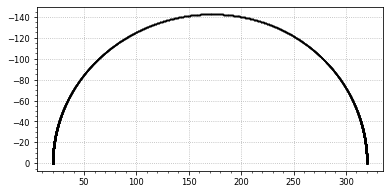

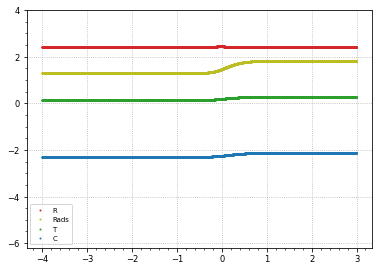

In [9]:
c = skx.eis.ElectrochemicalCircuit.from_string('Rel+Rct/Cox+R2/C2')
c.set_parameter_values(dict(zip(("Rel", 'Cox', 'Rct', "R2", "C2"), (20.0, 1e-2, 100, 200, 1e-2))))

w = np.logspace(4, -3, 7*1000)
f = w/(np.pi*2)
xi = (w,)

Z, scalc, s = c.simulate(xi)

ReZ = Z.real
ImZ = Z.imag
modZ = np.absolute(Z)
phase = np.angle(Z, deg=True)

dia = DifferentialImpedanceAnalysis(f, ReZ, ImZ)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.plot(ReZ, ImZ, 'k.', ms=1)

ax.invert_yaxis()


plt.figure()

x = np.log10(dia.lom_parameters['f'])

for param in dia.lom_parameter_names:
    print(param)
    y = np.log10(dia.lom_parameters[param])
    plt.plot(x, y, marker='.', ms=2, color=dia.colors[param], label=param)

plt.ylim(-6.2, 4)

plt.legend()


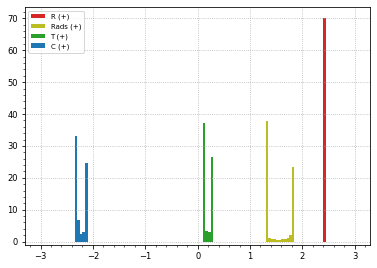

In [16]:
s = 0.05
for param in dia.lom_parameter_names:
    sign = '+'
    r = dia.spectral_analysis(s=s, parameter=param, sign=sign)
    if r is not None:
        plt.bar(r['logP'], r['I /dB'], width=s, color=dia.colors[param], align='edge', label=param + " ({0:s})".format(sign))
    
plt.ylim(-1, )
plt.legend()

(-3.0, 3.0)

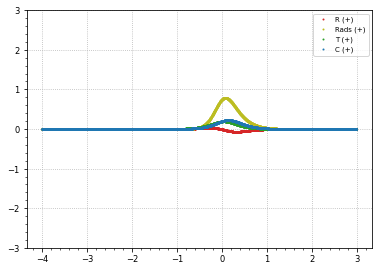

In [12]:
for param in dia.lom_parameter_names:
    sign="+"
    r = dia.differential_temporal_analysis(parameter=param, sign=sign)
    if r is not None:
        plt.plot(r['f'], r['delta_P'], marker='.', ms=2, ls='', color=dia.colors[param], label= param+ " ({0:s})".format(sign))
    
plt.legend()
plt.ylim(-3, 3)

(-2.0, 2.0)

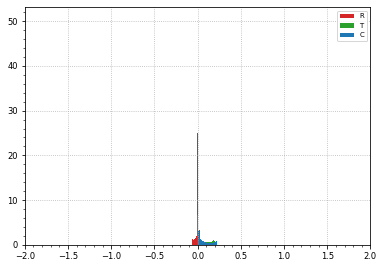

In [14]:
s = 0.01
for param in dia.lom_parameter_names:
    
    if param == 'Rads':
        pass
    else:
        r = dia.differential_spectral_analysis(s=s, parameter=param, sign="+")
        plt.bar(r['log_dP'], r['I /dB'], width=s, color=dia.colors[param], align='edge', label=param)
    
plt.legend()
plt.xlim(-2, 2)

In [212]:
10**-0.5

0.31622776601683794

In [3]:
C = skx.eis.ElectrochemicalCircuit.q2c_nd(2e-4, 0.46, 174)
print(C)
d = skx.eis.ElectrochemicalCircuit.c2d(eps=22, capacitance=C, area=65.0e-4)
print(d)
D = skx.eis.ElectrochemicalCircuit.d2D(d, tau=48)
print(D)

3.881243116198621e-06
3.262225063784449e-07
2.217106743079886e-15


In [4]:
skx.eis.ElectrochemicalCircuit.get_c_warburg(D*1e4, 669.0, d*1e6, 65.0, 360.0) 

0.0013529789789748043

In [8]:
C = skx.eis.ElectrochemicalCircuit.q2c_sd(2e-4, 0.46, 82, 174.0)
print(C)
d = skx.eis.ElectrochemicalCircuit.c2d(eps=80, capacitance=C, area=65.0e-4)
print(d*1e6)
D = skx.eis.ElectrochemicalCircuit.d2D(d, tau=48)
print(D*1e4)

8.108940915773239e-11
56779.02589843895
0.6716370379115836


In [1]:
%config Completer.use_jedi = False

In [2]:
import skelectrox as skx

In [3]:
c = skx.utilities.Function.from_string('f[a,b](x)=a*x+b')

print(c.prm_array_as_rst)

===== ========= ====== ========= ========= ========= ========= ============ ========= ========= ========= 
Names Values    Errors Errors /% Min       Max       Fixed     LogRandomize LogScan   Sign      Period    
===== ========= ====== ========= ========= ========= ========= ============ ========= ========= ========= 
a     +1.00e+00 +nan   +nan      +1.00e-20 +1.00e+20 +0.00e+00 +1.00e+00    +0.00e+00 +1.00e+00 +0.00e+00 
b     +1.00e+00 +nan   +nan      +1.00e-20 +1.00e+20 +0.00e+00 +1.00e+00    +0.00e+00 +1.00e+00 +0.00e+00 
===== ========= ====== ========= ========= ========= ========= ============ ========= ========= ========= 


In [4]:
print(c.parameter_array_as_md)

|Names|Values   |Errors|Errors /%|Min      |Max      |Fixed    |LogRandomize|LogScan  |Sign     |Period   |
|-----|---------|------|---------|---------|---------|---------|------------|---------|---------|---------|
|a    |+1.00e+00|+nan  |+nan     |+1.00e-20|+1.00e+20|+0.00e+00|+1.00e+00   |+0.00e+00|+1.00e+00|+0.00e+00|
|b    |+1.00e+00|+nan  |+nan     |+1.00e-20|+1.00e+20|+0.00e+00|+1.00e+00   |+0.00e+00|+1.00e+00|+0.00e+00|


In [5]:
c.float_formatter = "+.4e"

In [6]:
print(c.parameter_array_as_md)

|Names|Values     |Errors|Errors /%|Min        |Max        |Fixed      |LogRandomize|LogScan    |Sign       |Period     |
|-----|-----------|------|---------|-----------|-----------|-----------|------------|-----------|-----------|-----------|
|a    |+1.0000e+00|+nan  |+nan     |+1.0000e-20|+1.0000e+20|+0.0000e+00|+1.0000e+00 |+0.0000e+00|+1.0000e+00|+0.0000e+00|
|b    |+1.0000e+00|+nan  |+nan     |+1.0000e-20|+1.0000e+20|+0.0000e+00|+1.0000e+00 |+0.0000e+00|+1.0000e+00|+0.0000e+00|


In [7]:
print(c.prm_array_as_rst)

===== =========== ====== ========= =========== =========== =========== ============ =========== =========== =========== 
Names Values      Errors Errors /% Min         Max         Fixed       LogRandomize LogScan     Sign        Period      
===== =========== ====== ========= =========== =========== =========== ============ =========== =========== =========== 
a     +1.0000e+00 +nan   +nan      +1.0000e-20 +1.0000e+20 +0.0000e+00 +1.0000e+00  +0.0000e+00 +1.0000e+00 +0.0000e+00 
b     +1.0000e+00 +nan   +nan      +1.0000e-20 +1.0000e+20 +0.0000e+00 +1.0000e+00  +0.0000e+00 +1.0000e+00 +0.0000e+00 
===== =========== ====== ========= =========== =========== =========== ============ =========== =========== =========== 


In [1]:
import skelectrox as skx

In [2]:
e = 2.543e-6
skx.utilities.Function.round_errors(e, ceil=True, p=2)

array([2.6e-06])

In [6]:
e = 2.443e9
skx.utilities.Function.round_errors(e, ceil=False, p=2)

array([2.4e+09])